<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/chronic_conditions_emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unsupervised, Generative Knowledge Graphs
  Produce enormous graph networks, based on time-series correlation between topics
  1.  Get an OpenAi token, save to a file and import, ex. 'openai_key'
  2.  Input list of seed topics that you want expanded upon
  3.  Experiment with new variations in OpenAi questioning format

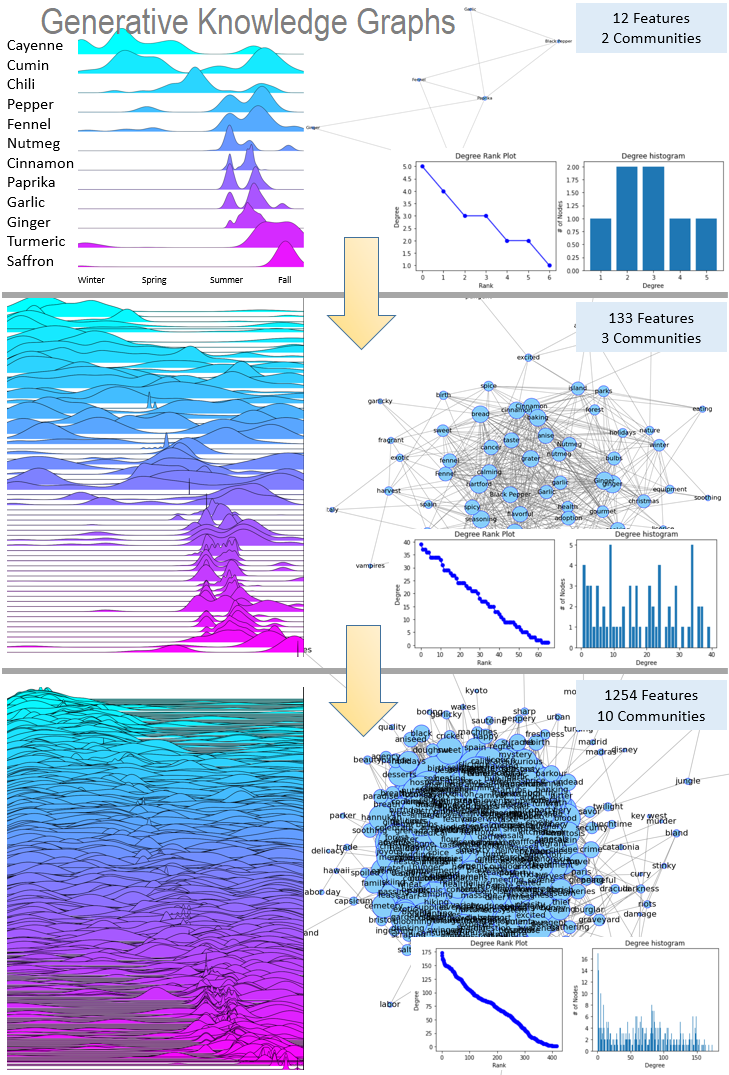

## installs

In [79]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai
!pip install dgl

## imports

In [80]:
import numpy
import pandas 
import re
import string

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [81]:
### Generative Seeds, topics and question formatting to feed to OpenAi

# seed topics
topics = ['Type 1 diabetes', 'Type 2 diabetes', 'Cardiovascular disease', 'Rheumatoid arthritis'
         ,'Coronary artery disease', 'Multiple sclerosis', 'Stroke', 'Clots', 'Hemorrhage', 'Epilepsy '
         ,'Arthritis', 'Cancer', 'High blood pressure', 'Obesity', 'Alzheimer', 'Hospice', 'Tooth decay']


# request object
req_obj = ['concepts', 'styles', 'cities', 'emotions','concerns', 'attitudes', 'alternatives', 'regions'
         , 'life events', 'yearly events', 'life style', 'behaviors'
         , 'holidays']



### Generative Bounds, prescribe factors needed to control generative iterations

# connection strenth minimum boost, base on standard deviation
std_factor = .7
pop_threshold = .4

# batch size
batch_size = 30

# max fetch
max_fetch = 100

## helper functions
  1. get_trend_frame(topics, years): 
          returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features): 
          form graph source/target relationships
  3. build_node_labels(df_flat): 
          generate labels based on time interval
  4. get_ridgeplot(df_flat):
          visualize temporal attributes
  5. get_openai_response(question):
          using standard format, prompt openai for new top lists
  6. get_pairwise_similarity(df_features, topics, std_factor): 
          for combinations of topics, get temporal correlation
  7. swap_tokens(chk_topics, new_topics):
          replace any duplicates between existing and new features
  8. build_graph_network(df_slice):
          buiod graph
  9. get_openai_generated_topics(topic, obj):
          form openAi question given generative seeds
  10. get_related_topics(df):
          mechanism for enhancing graph based on generative seeds
  11. get_graph_degree(G):
          get graph statisitcs for feeding into downstream predictive models

In [82]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo="US"
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # counters
    batch_counter+=1
    fetch_idx+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]


    except:
      print('failed to add topic - %s ' % (topic))


  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [83]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [84]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [85]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cm.cool                         
                            , ylim='own'
                          )

  # write ridgeplot
  plt.savefig('frank_jj.png')

  # plot
  plt.show()

In [86]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.01,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [87]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [88]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [89]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='lightskyblue'
      ,node_size=[v * 100 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

In [90]:
def get_openai_generated_topics(topic, obj):
  
  new_tokens_list = []

  responses = []

  # retrieve 
  retrieval = get_openai_response('from the perspetive of a Texas resident, list one word %s related to %s' % (obj , topic))
  # retrieval = get_openai_response('list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())

  return new_tokens

In [91]:
def get_related_topics(df):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  for graph_topic in graph_topics:

    # if match is hit
    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    for obj in req_obj:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(graph_topics) * len(req_obj) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
        fetch_idx+=1
      
      # counters
      batch_counter+=1
      
    
  return lst_buffer

In [92]:
def get_graph_degree(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  fig = plt.figure("Degree of a random graph", figsize=(8, 8))
  # Create a gridspec for adding subplots of different sizes
  axgrid = fig.add_gridspec(5, 4)

  ax0 = fig.add_subplot(axgrid[0:3, :])
  Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
  pos = nx.spring_layout(Gcc, seed=10396953)
  nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
  nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
  ax0.set_title("Connected components of G")
  ax0.set_axis_off()

  ax1 = fig.add_subplot(axgrid[3:, :2])
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  ax2 = fig.add_subplot(axgrid[3:, 2:])
  ax2.bar(*numpy.unique(degree_sequence, return_counts=True))
  ax2.set_title("Degree histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()

## gather, pre-process and stage graph data structure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


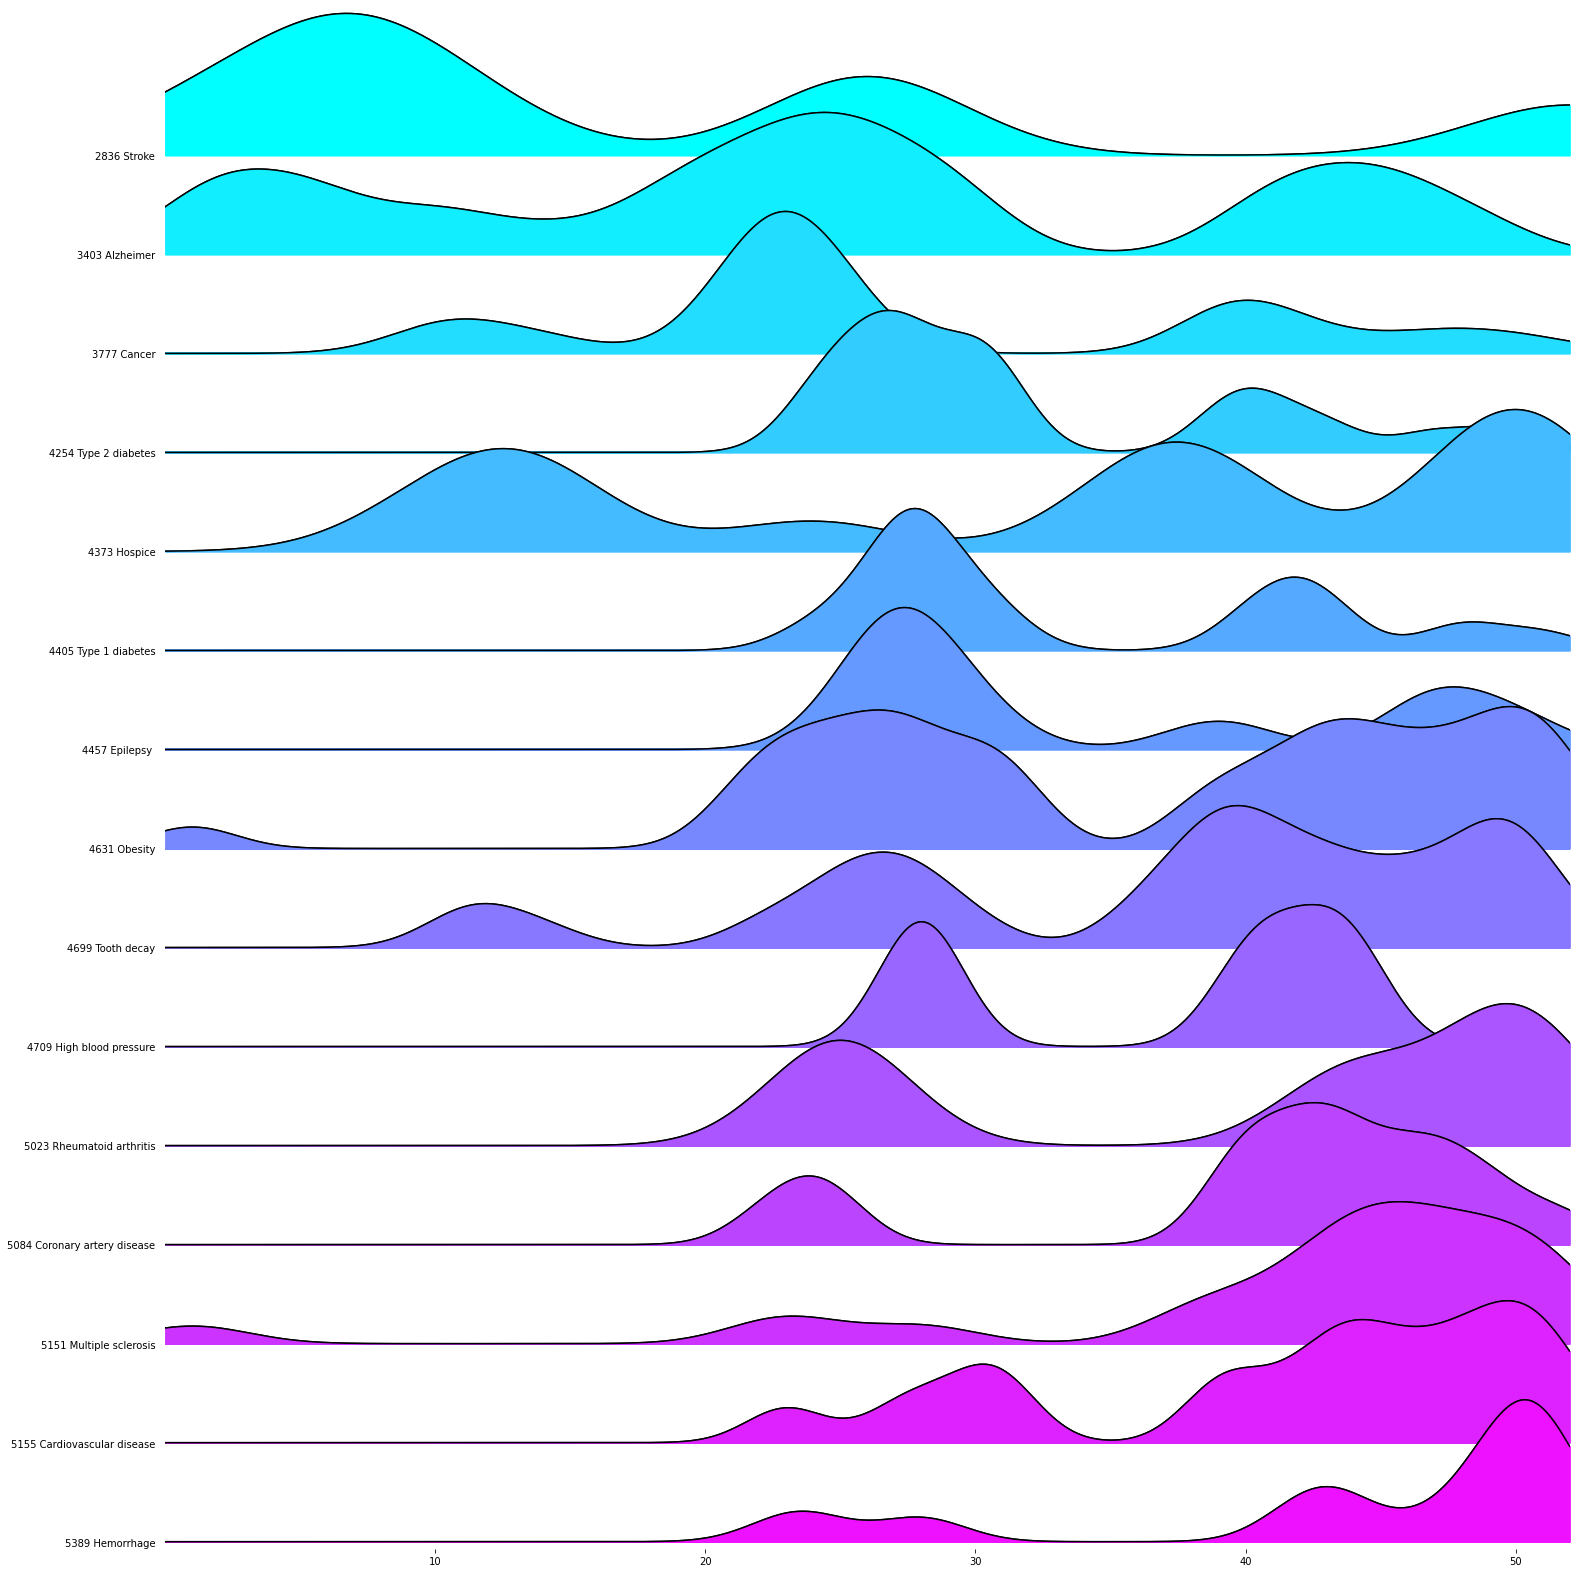

In [93]:
# request features
df_features = get_trend_frame(topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

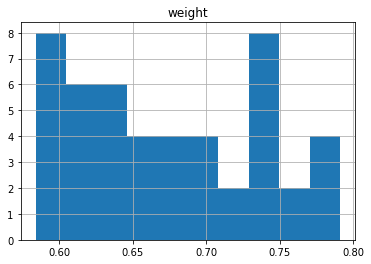

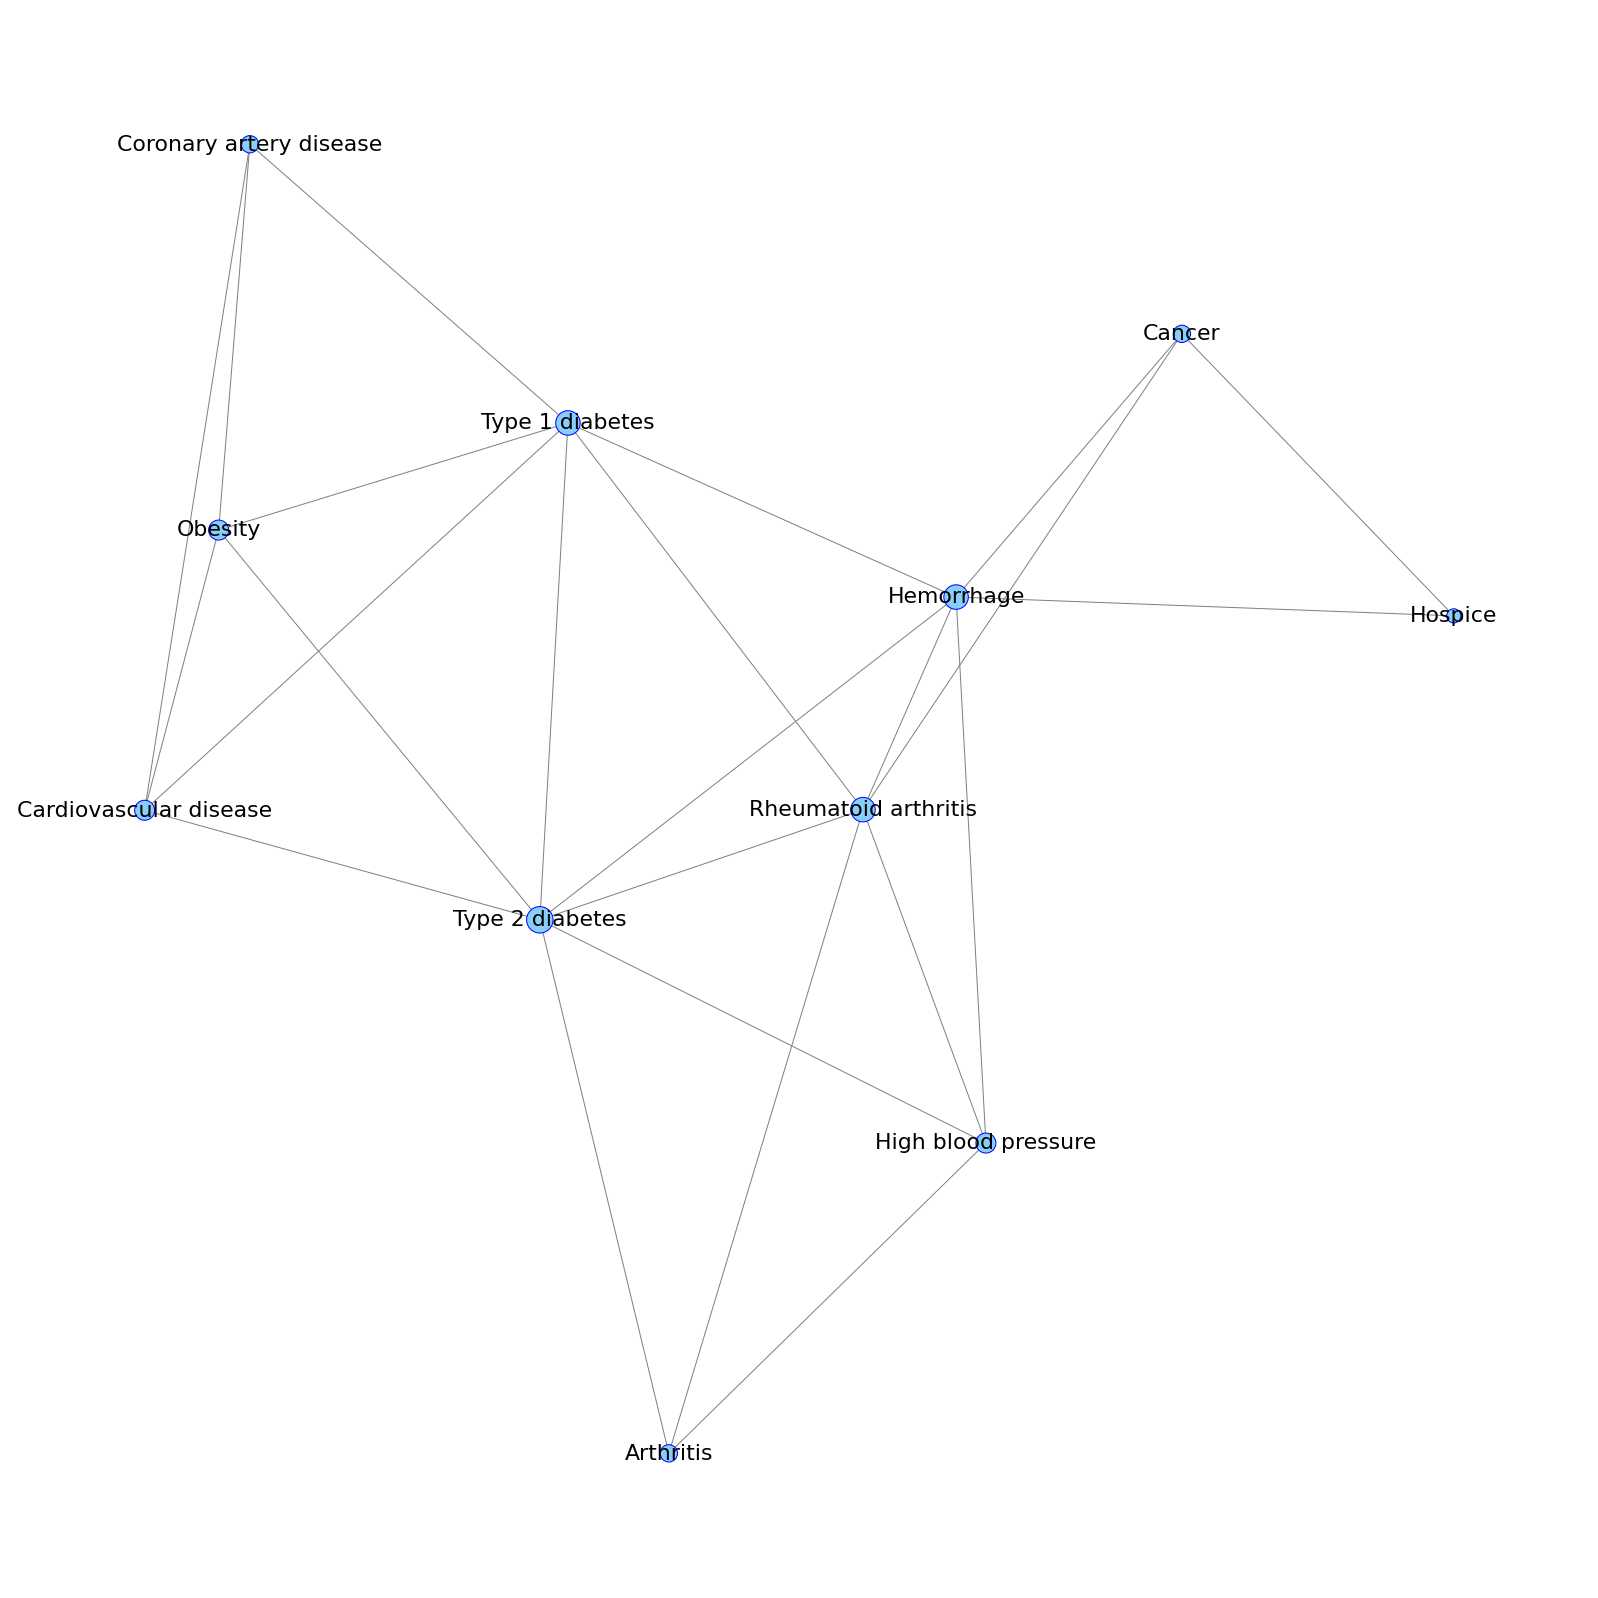

In [94]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)
orginal_G = G

Communities found - 3 

Community 0 - ['Cardiovascular disease', 'Coronary artery disease', 'Obesity', 'Type 1 diabetes']
Community 1 - ['Arthritis', 'High blood pressure', 'Rheumatoid arthritis', 'Type 2 diabetes']
Community 2 - ['Cancer', 'Hemorrhage', 'Hospice']


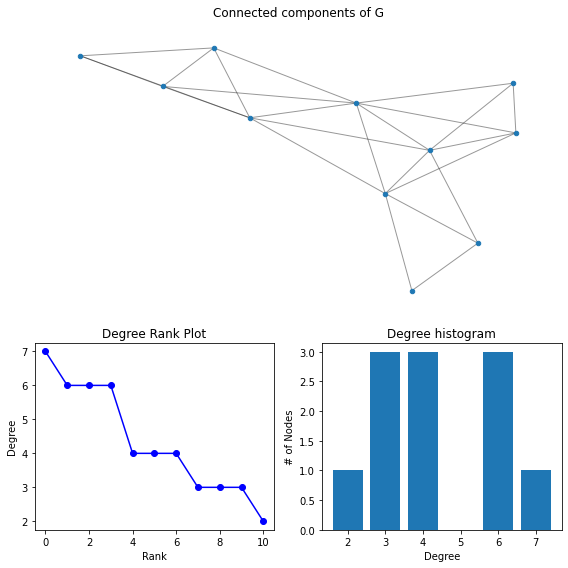

In [95]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [96]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)


completed openai retrieval of batch 1 - 30 rows of 143

completed openai retrieval of batch 2 - 60 rows of 143
hit local max of 121
['stress', 'houston', 'dallas', 'stress', 'anxiety', 'concern', 'stress', 'stress', 'stroke', 'stroke', 'stress', 'painful', 'houston', 'dallas', 'texas', 'arthritis', 'blood', 'injury', 'bloody', 'houston', 'dallas', 'blood', 'injury', 'bloody', 'bleeding', 'bursting', 'blood', 'injury', 'birth', 'death', 'bleeding', 'bursting', 'insulin', 'austin', 'insulin', 'needles', 'awareness', 'texas', 'diabetes', 'carefree', 'careful', 'diligent', 'houston', 'dallas', 'anguish', 'anxiety', 'stroke', 'heart', 'artery', 'stroke', 'smoking', 'smoking', 'obesity', 'heart']
['arthritis', 'Arthritis', 'injury', 'texas', 'Cancer', 'needles', 'anxiety', 'bursting', 'Type 1 diabetes', 'Coronary artery disease', 'awareness', 'bleeding', 'bloody', 'stress', 'diligent', 'artery', 'blood', 'Obesity', 'dallas', 'Cardiovascular disease', 'painful', 'anguish', 'obesity', 'insuli


completed retrieval of batch 1 - 30 rows of 40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (4) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (4.0) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group wit

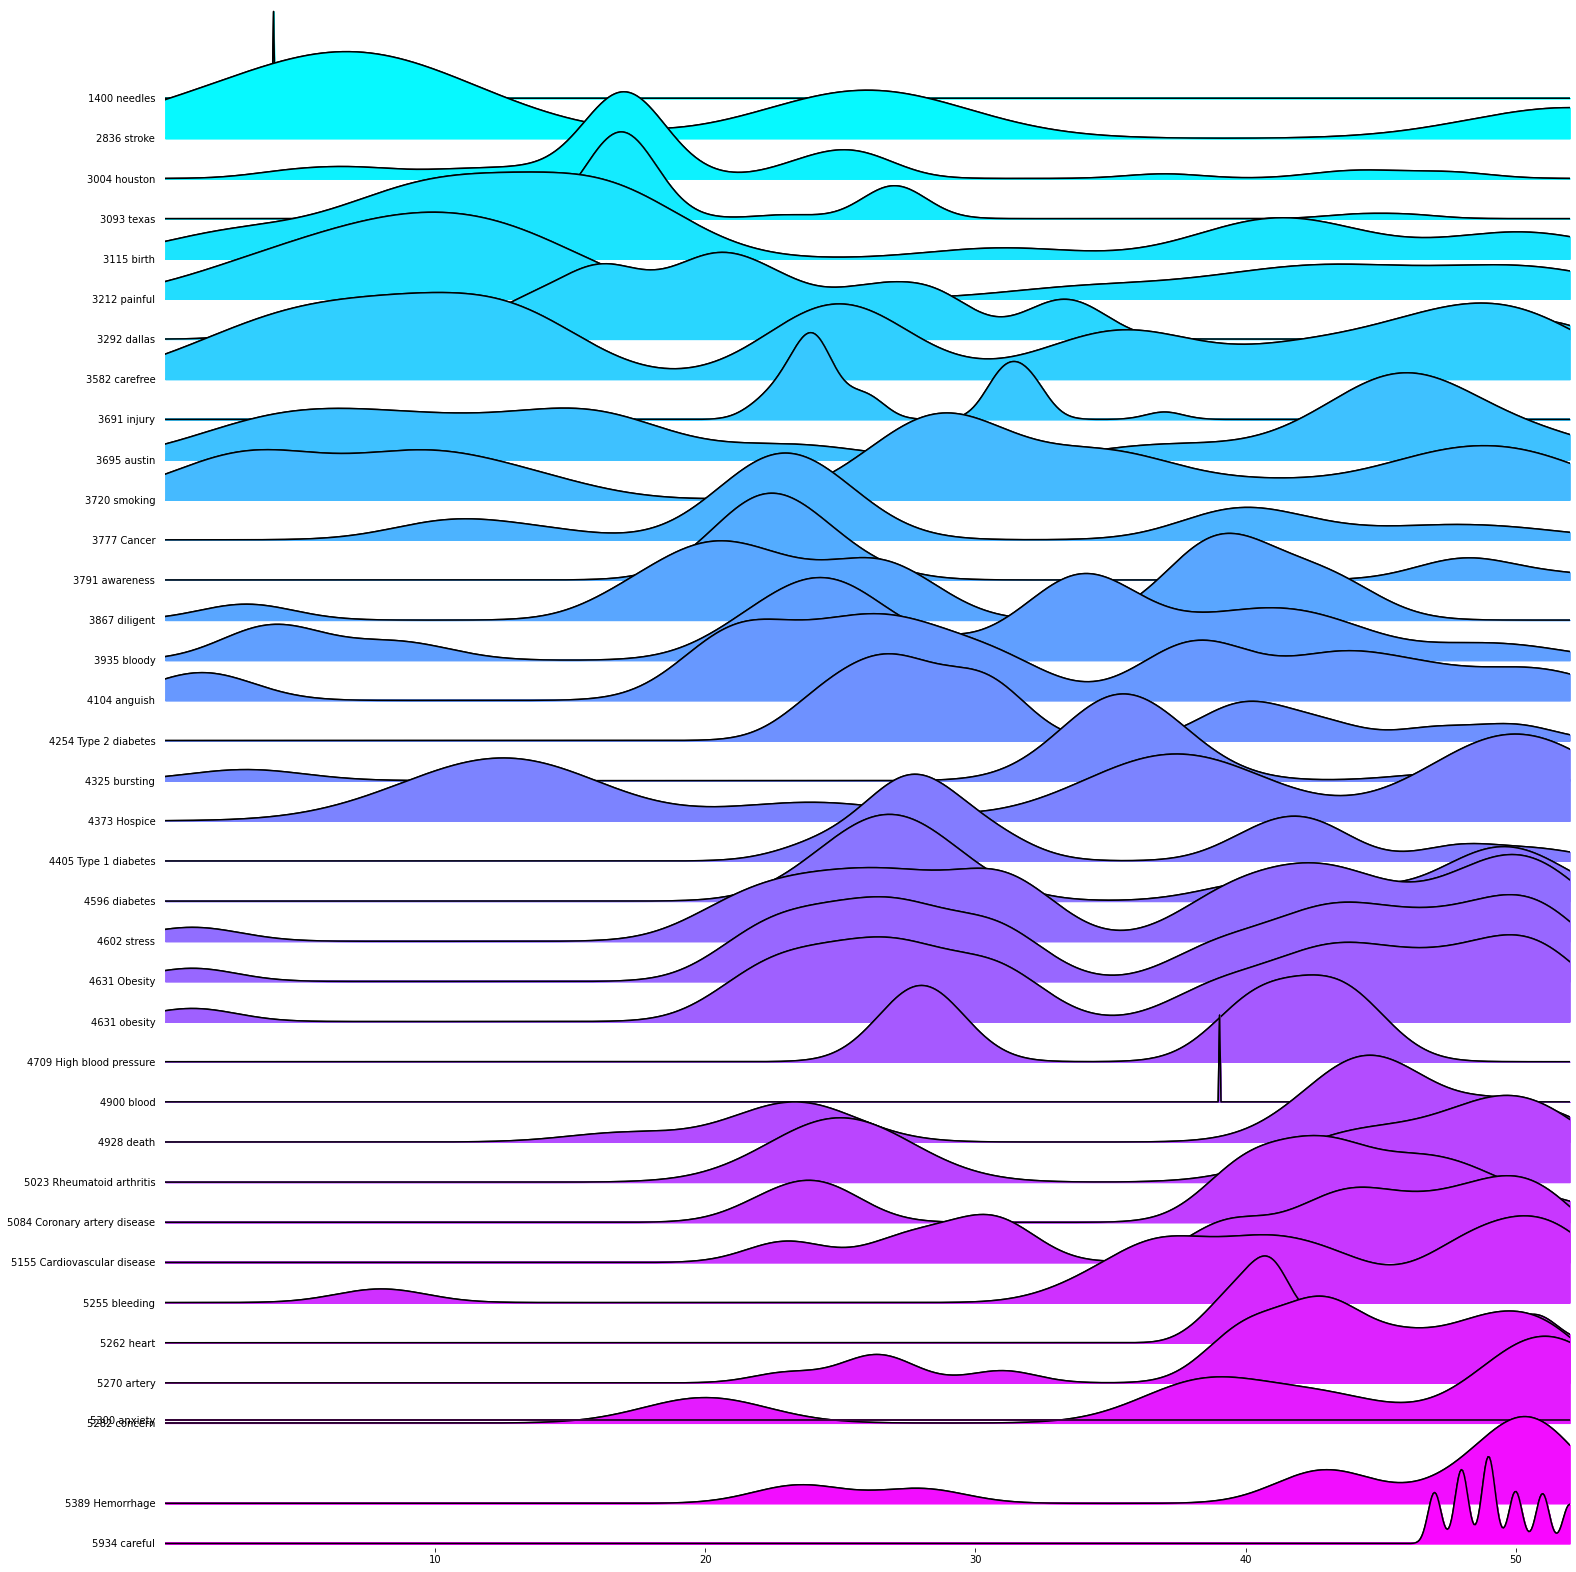

In [97]:
# request features
#df_features = get_trend_frame(gen_topics, '5')[gen_topics]
df_features = get_trend_frame(gen_topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

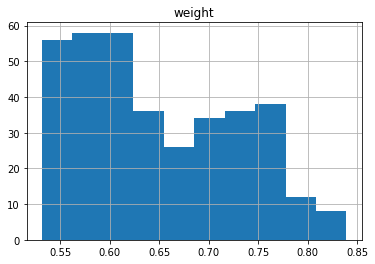

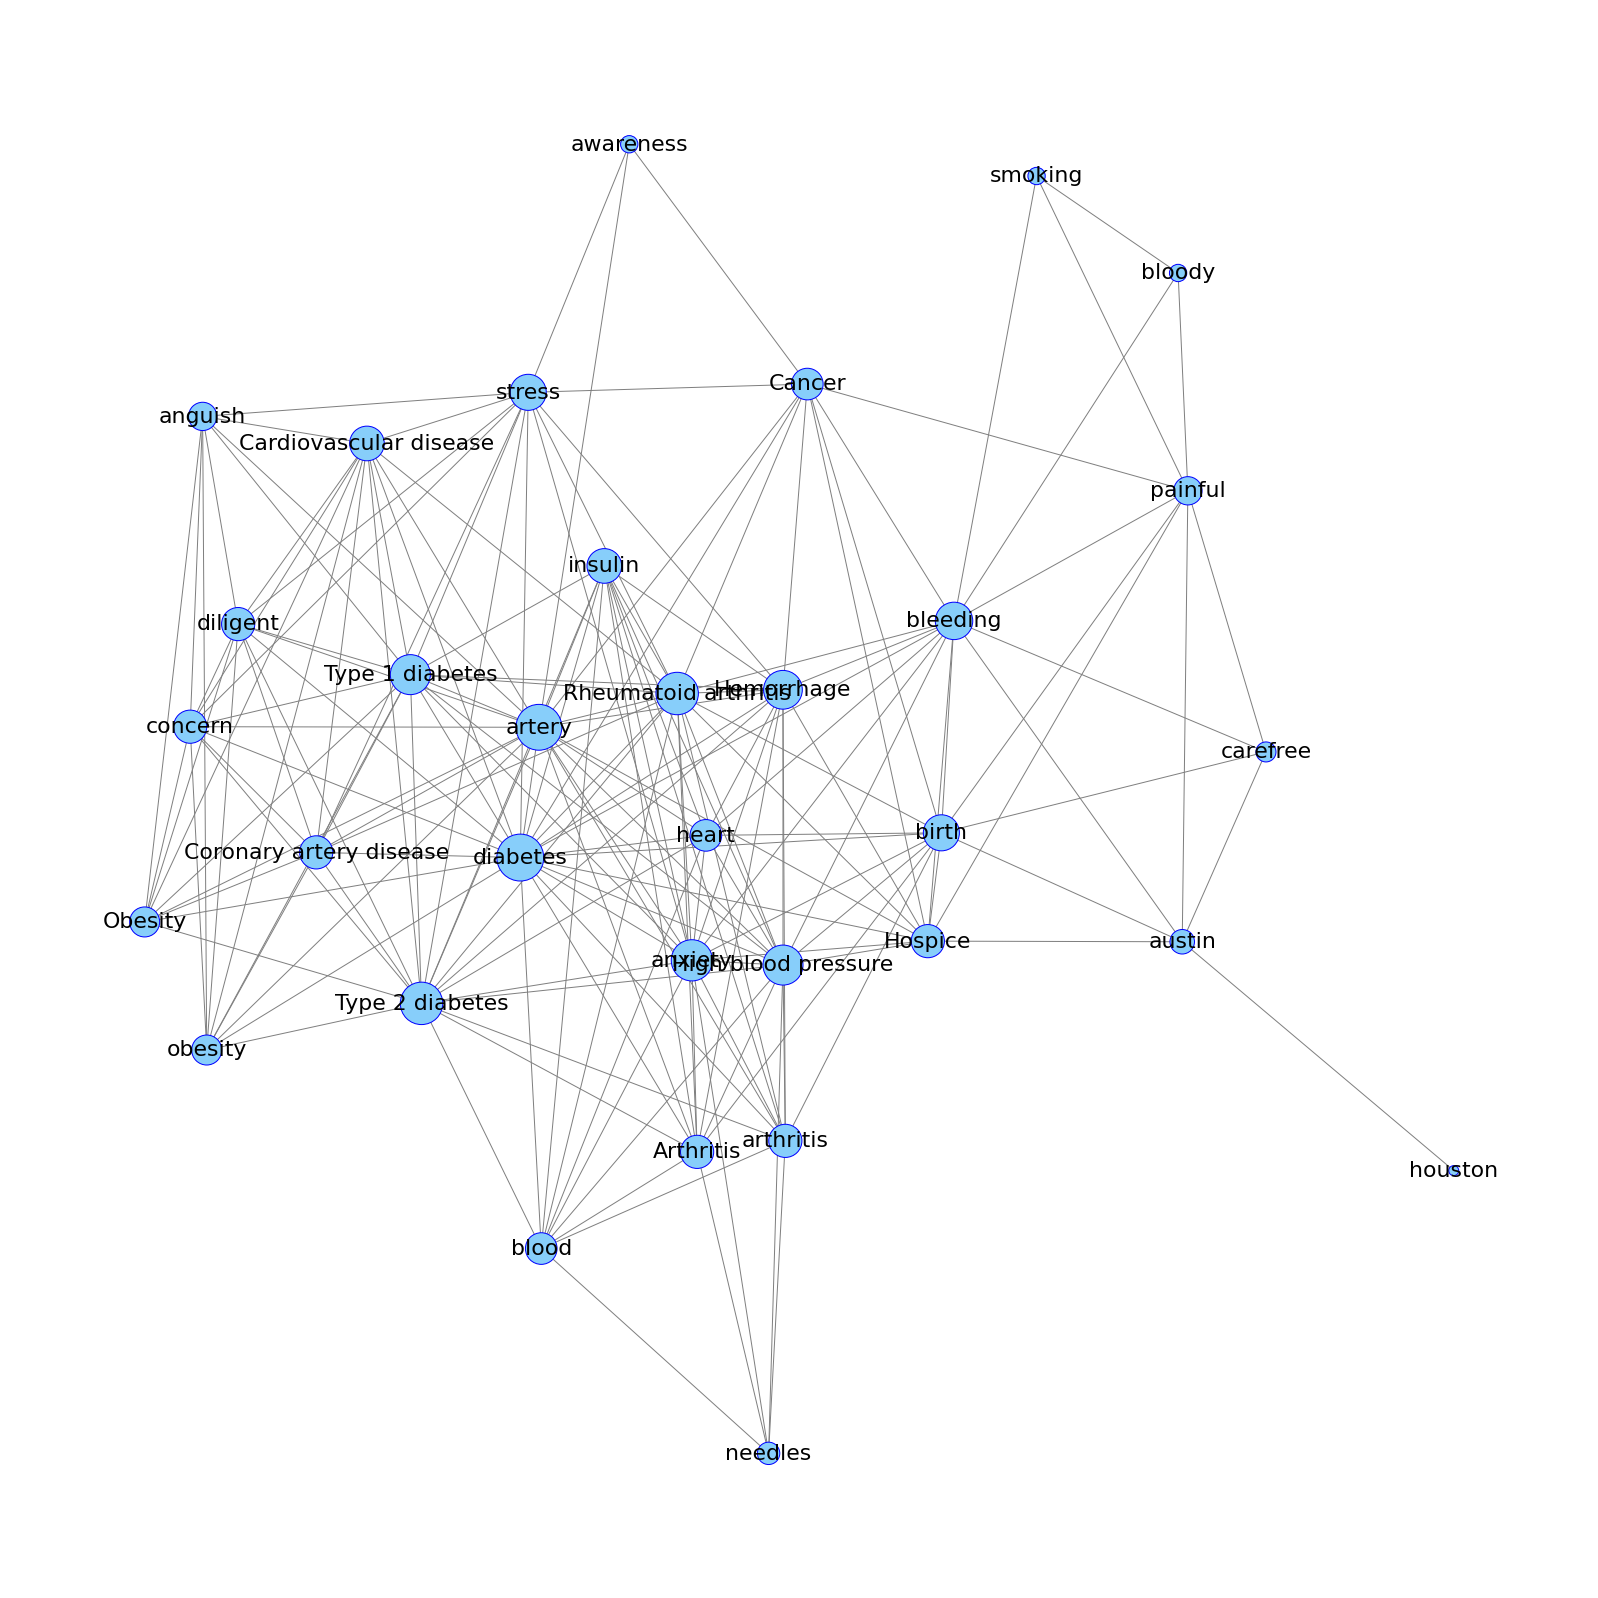

In [98]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)
second_G = G

Communities found - 3 

Community 0 - ['Cardiovascular disease', 'Coronary artery disease', 'Obesity', 'Type 1 diabetes', 'anguish', 'artery', 'awareness', 'concern', 'diabetes', 'diligent', 'obesity', 'stress']
Community 1 - ['Arthritis', 'Hemorrhage', 'High blood pressure', 'Rheumatoid arthritis', 'Type 2 diabetes', 'anxiety', 'arthritis', 'blood', 'heart', 'insulin', 'needles']
Community 2 - ['Cancer', 'Hospice', 'austin', 'birth', 'bleeding', 'bloody', 'carefree', 'houston', 'painful', 'smoking']


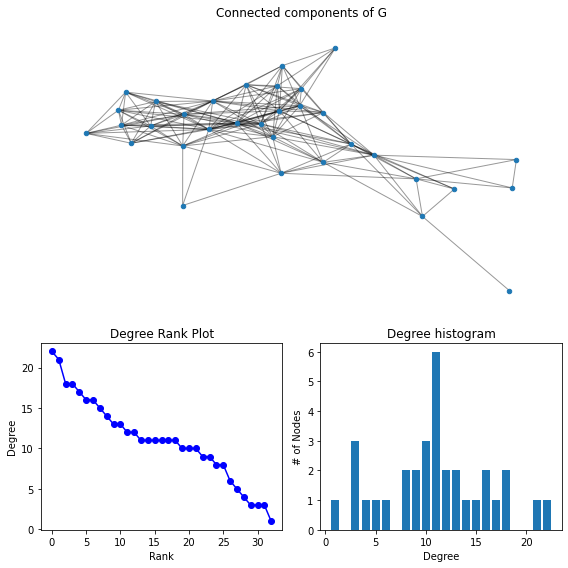

In [99]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [100]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('diabetes', 22),
 ('artery', 21),
 ('Type 2 diabetes', 18),
 ('Rheumatoid arthritis', 18),
 ('anxiety', 17),
 ('High blood pressure', 16),
 ('Type 1 diabetes', 16),
 ('Hemorrhage', 15),
 ('bleeding', 14),
 ('birth', 13)]

In [101]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)


completed openai retrieval of batch 1 - 30 rows of 429
hit local max of 107
['stress', 'houston', 'dallas', 'stress', 'anxiety', 'concern', 'stress', 'stress', 'stroke', 'stroke', 'stress', 'gushing', 'oozing', 'houston', 'dallas', 'south', 'central', 'abortion', 'liberal', 'painful', 'stiff', 'houston', 'dallas', 'suffering', 'joints', 'flareups', 'suffering', 'blood', 'injury', 'bloody', 'houston', 'dallas', 'shock', 'blood', 'injury', 'bloody', 'bleed', 'burst', 'blood', 'injury', 'birth', 'death', 'bleeding', 'bursting']
['gushing', 'joints', 'arthritis', 'Arthritis', 'suffering', 'oozing', 'injury', 'Cancer', 'needles', 'anxiety', 'flareups', 'bursting', 'stiff', 'awareness', 'Type 1 diabetes', 'Coronary artery disease', 'south', 'central', 'bleeding', 'bloody', 'diligent', 'stress', 'artery', 'blood', 'Obesity', 'burst', 'abortion', 'dallas', 'Cardiovascular disease', 'painful', 'anguish', 'obesity', 'shock', 'insulin', 'Type 2 diabetes', 'austin', 'Hemorrhage', 'bleed', 'heart'


completed retrieval of batch 1 - 30 rows of 51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (4) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group with a single distinct value (4.0) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:288: UserWarning: The data contains a group wit

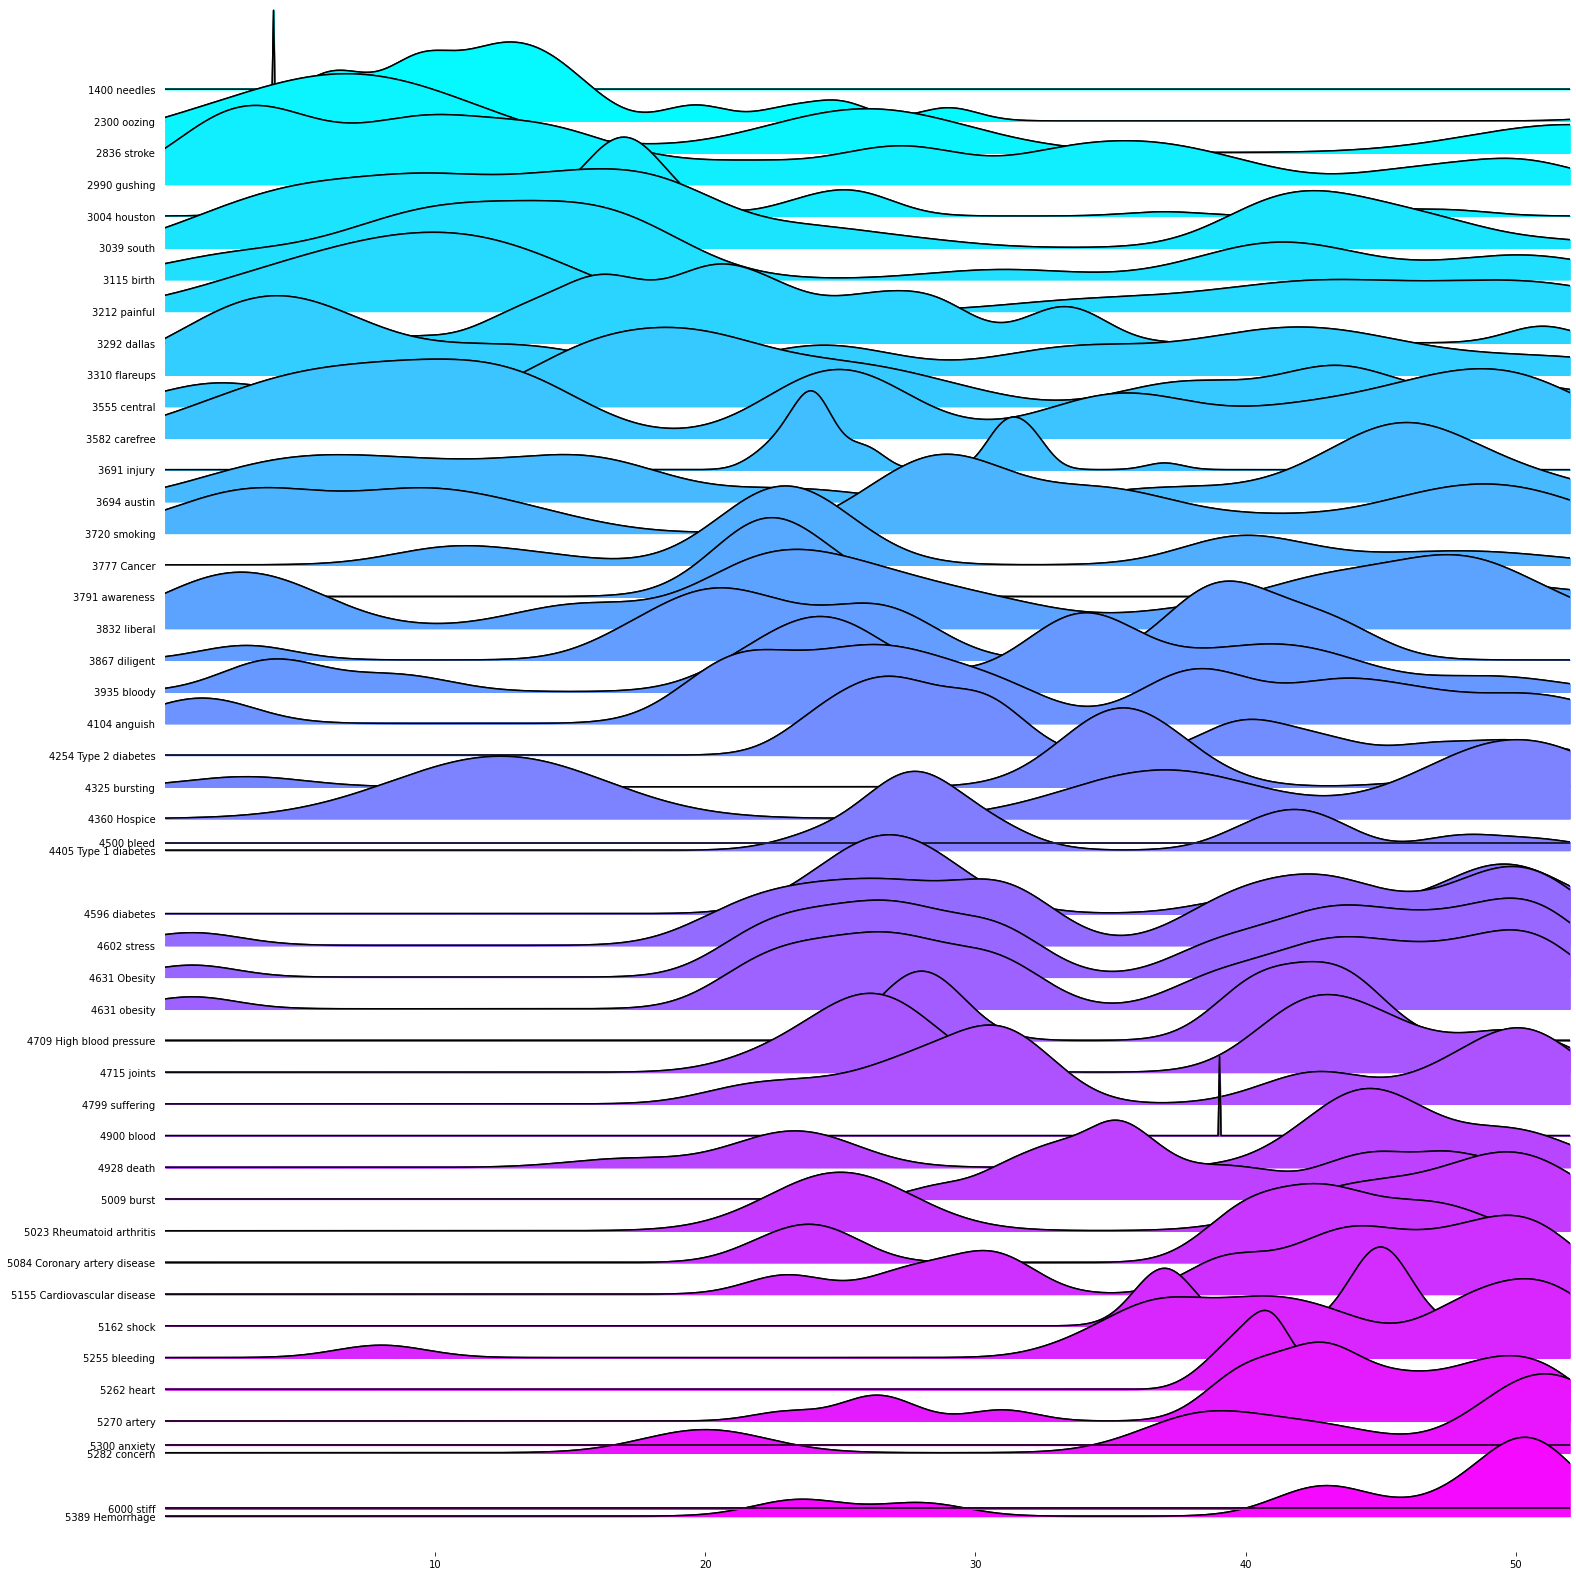

In [102]:
# request features
df_features = get_trend_frame(gen_topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

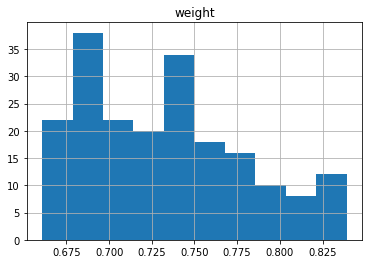

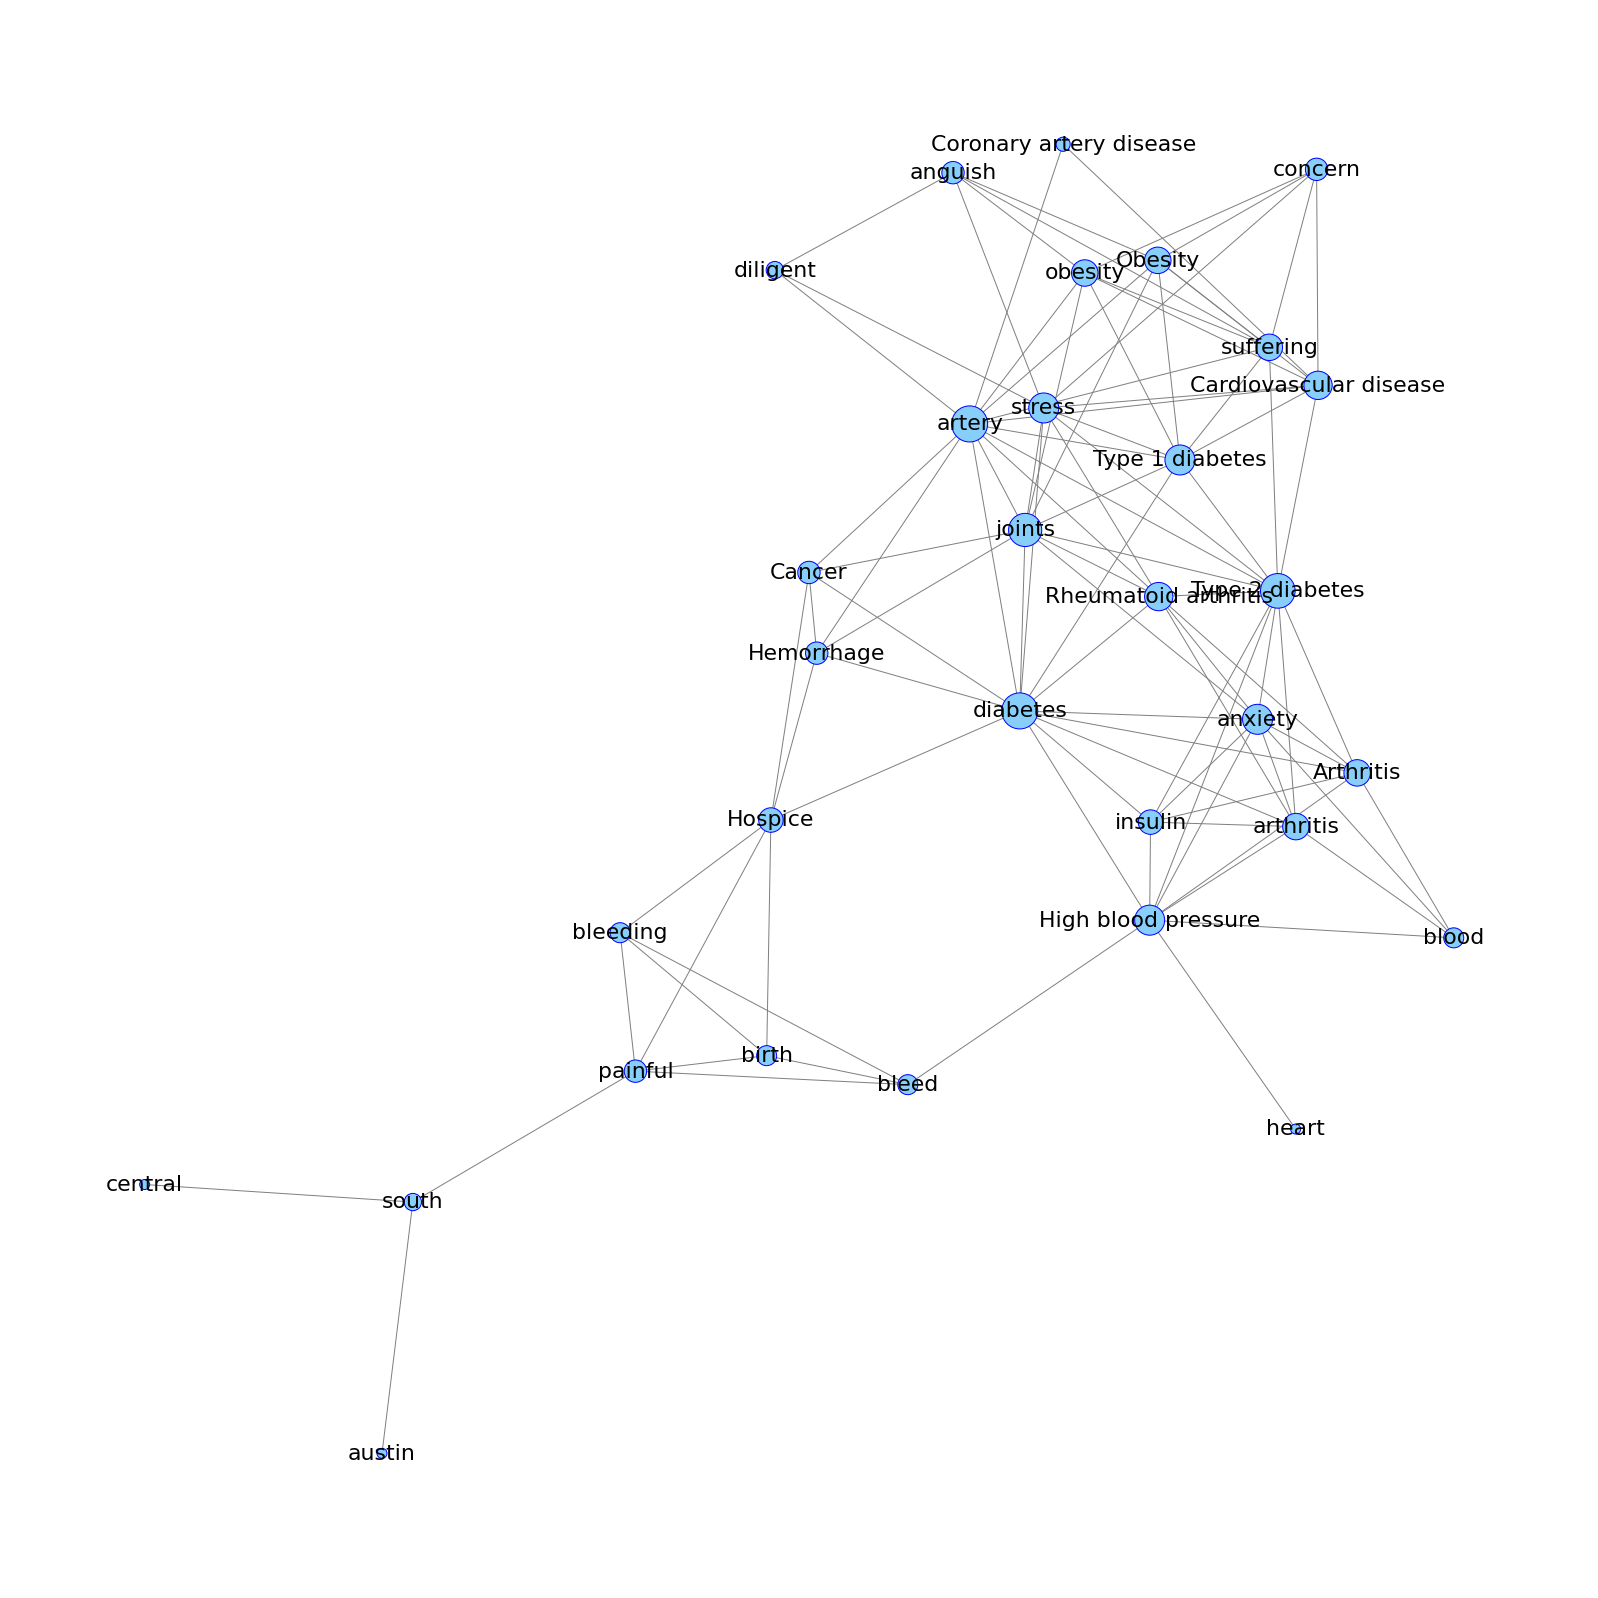

In [103]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

Communities found - 4 

Community 0 - ['Cardiovascular disease', 'Coronary artery disease', 'Obesity', 'Type 1 diabetes', 'anguish', 'artery', 'concern', 'diligent', 'obesity', 'stress', 'suffering']
Community 1 - ['Arthritis', 'High blood pressure', 'Rheumatoid arthritis', 'Type 2 diabetes', 'anxiety', 'arthritis', 'blood', 'heart', 'insulin']
Community 2 - ['Hospice', 'austin', 'birth', 'bleed', 'bleeding', 'central', 'painful', 'south']
Community 3 - ['Cancer', 'Hemorrhage', 'diabetes', 'joints']


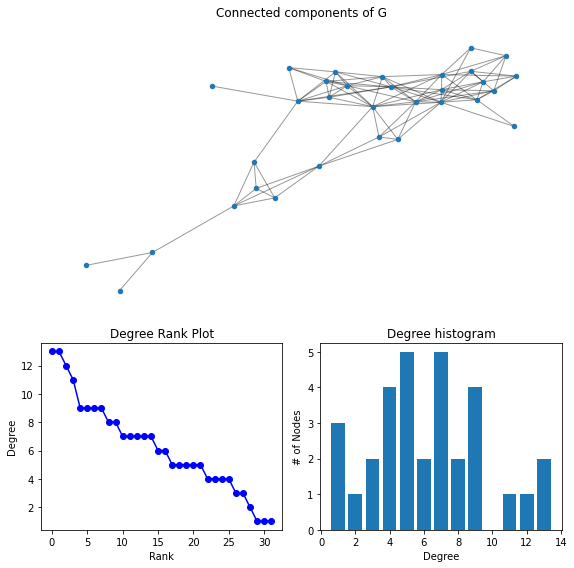

In [104]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [109]:
!pip install visJS2jupyter

  Created wheel for visJS2jupyter: filename=visJS2jupyter-0.1.16-py3-none-any.whl size=22473 sha256=1bce8ee0e0d354f5ccba4c36edfeec4b867ea8e1e8da5de75c827d102f65f745
  Stored in directory: /root/.cache/pip/wheels/72/c8/3a/7de50e62a8924510c97dc8536b7620b4fdbe03ee1ff5ce2c1a
Successfully built visJS2jupyter


In [113]:
import visJS2jupyter.visualizations as visualizations
#import visualizations as visualizations
import visJS2jupyter.visualizations as visualizations
import imp
imp.reload(visualizations)

<module 'visJS2jupyter.visualizations' from '/usr/local/lib/python3.7/dist-packages/visJS2jupyter/visualizations.py'>

['Florida-Cardiovascular disease', 'Florida-Type 2 diabetes', 'Florida-joints', 'Florida-obesity', 'Florida-Obesity', 'Florida-Cancer', 'Florida-Hemorrhage', 'Florida-Type 1 diabetes', 'Florida-diabetes', 'Florida-Hospice', 'Florida-bleeding', 'Florida-bleed', 'Florida-diligent', 'Florida-artery', 'Florida-stress', 'Florida-Rheumatoid arthritis', 'Florida-painful', 'Florida-birth', 'Florida-anguish', 'Florida-concern', 'Florida-heart', 'Florida-High blood pressure', 'Florida-insulin', 'Florida-arthritis', 'Florida-Arthritis', 'Florida-suffering', 'Florida-blood', 'Florida-central', 'Florida-south', 'Florida-Coronary artery disease', 'Florida-anxiety', 'Florida-austin', 'Texas-High blood pressure', 'Texas-Rheumatoid arthritis', 'Texas-Hemorrhage', 'Texas-Type 1 diabetes', 'Texas-Coronary artery disease', 'Texas-Cancer', 'Texas-Obesity', 'Texas-Type 2 diabetes', 'Texas-Cardiovascular disease', 'Texas-Hospice', 'Texas-Arthritis']


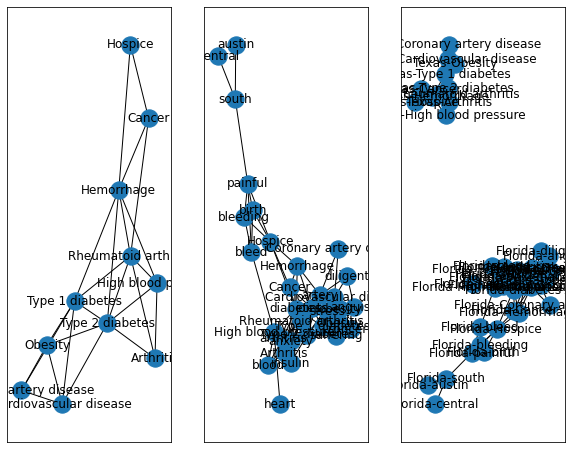

In [129]:
# visualizations.draw_graph_overlap(G,orginal_G,edge_width=5,node_name_1="Type 2 diabetes",node_name_2="Type 2 diabetes",physics_enabled=False)
_,ax = plt.subplots(1,3, figsize=(10,8))
nx.draw_networkx(orginal_G, ax=ax[0])
nx.draw_networkx(G, ax=ax[1])
U = nx.union(G, orginal_G, rename=('Florida-','Texas-'))
#U = nx.union(G, orginal_G, rename=('T','T'))
#U = nx.disjoint_union(G, orginal_G)
nx.draw_networkx(U, ax=ax[2])
print(U.nodes())